In [2]:
from __future__ import print_function
import argparse
import math
from math import log10
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from dataset import get_training_set, get_test_set
from tiles import tile, untile
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from bmode_visu import bmode_visu
import skimage
from skimage.feature import peak_local_max
import seaborn as sns
from scipy.spatial import distance
import pandas as pd

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Have bigger cells in Jupyter Notebook 

In [4]:
# Settings and hyperparameters
threads = 0
seed = 123

In [5]:
# Check for cuda
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
else:
    device = torch.device("cpu")

In [5]:
# # Test to normalize the data (not successful)
# # 0.1171 - 0.2253 07_noisy / 

# transform = transforms.Compose([
#     transforms.Normalize(0.1171, 0.2253)
# ])
# target_transform = transforms.Compose([
#     transforms.Normalize(0.1171, 0.2253)
# ])

# Data test selection

In [5]:
# Load the test set
# root = '../testing_set_numpy/eval_set_numpy_noisy/eval_set_32x32_batch_20/'
root = '../testing_set_numpy/testing_perf/eval_set_32x32_batch_30/'
test_set = get_test_set(transform=None, target_transform=None, root = root)
testing_data_loader = DataLoader(dataset=test_set, num_workers=threads, shuffle=False)

# Model selection

In [31]:
#Load the model
# model = torch.load("../trained_models/liu/model_07_noise/model_07_noise_5_24.pth")
model = torch.load("../trained_models/vansloun/model_07_noise/model_07_noise_9_15.pth")
model.cuda() # /!\ Remove .cuda() if we don't have cuda available /!\
model.eval()

DeepULMNet(
  (coordconv): CoordConv(
    (addcoords): AddCoords()
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (encoder1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128

# Model on test data

In [27]:
#Predict on all test data
criterion = nn.MSELoss().cuda()
predictions = []
inputs =  []
targets = [] 
mse = []
for batch in testing_data_loader:
    with torch.no_grad():
        model.eval()
        batch = batch
        input, target = Variable(batch[0].float()).cuda(), Variable(batch[1].float()).cuda() # /!\ Remove .cuda() if we don't have cuda available /!\
        prediction = model(input)
        predictions.append(prediction)
        inputs.append(input)
        targets.append(target)
        #mse.append(criterion(prediction, target).item())
        #psnr = 10 * log10(amplitude / mse.item())
        #avg_psnr += psnr

# Peak Local Max of Predicted

In [28]:
#Improve the localization using local_maxima estimation and threshold
coordinates = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        coordinates.append(peak_local_max(predictions[i][j,0,:,:].cpu().detach().numpy(), threshold_abs= 2, min_distance = 2))
        predictions_lmax = np.zeros((128,128,len(coordinates)))

for k in range(len(coordinates)):
    predictions_lmax[coordinates[k][:,0], coordinates[k][:,1], k] = 1      


# Visualization

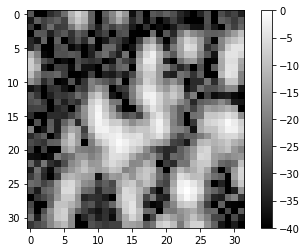

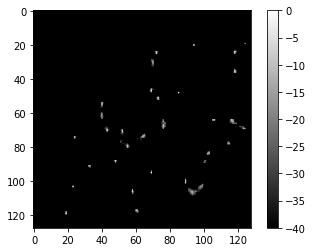

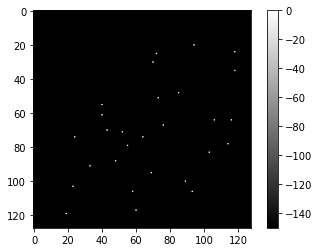

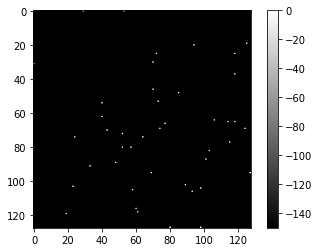

In [9]:
# Look at the input, prediction, prediction_lmax, target for a specified range
for i in range(270,271):
    for j in range(predictions[i].size()[0]):
        bmode_visu(inputs[i][j,0,:,:].cpu().detach().numpy()) # /!\ Remove .cpu() if we don't have cuda available /!\
        bmode_visu(predictions[i][j,0,:,:].cpu().detach().numpy()) # /!\ Remove .cpu() if we don't have cuda available /!\
        bmode_visu(predictions_lmax[:,:,i],150)
        bmode_visu(targets[i][j,0,:,:].cpu().detach().numpy(), 150) # /!\ Remove .cpu() if we don't have cuda available /!\

# Tiled

In [35]:
# Loading a .mat file and save it to a .npz file
import numpy as np
import scipy.io
from pathlib import Path

data = scipy.io.loadmat('../DL_flow/multiflow_DL_c_30_snr5.mat')
# data = scipy.io.loadmat('../DL_flow/IQ_couture.mat') # Couture

flow_set  = data['IQc']
# flow_set  = data['absSf'] # Couture
dirac_all = data['dirac_truth']

np.savez('../DL_flow/flow_simu_raw.npz', flow_set)
# np.savez('../DL_flow/flow_simu_raw_2.npz', flow_set) # Couture
np.savez('../DL_flow/flow_simu_truth.npz', dirac_all)

In [32]:
# Couture
container_raw = np.load('../DL_flow/flow_simu_raw_2.npz')
IQc_raw = np.array([container_raw[key] for key in container_raw])
IQc_tiled_raw = tile(IQc_raw[0][0:64,:,], 32)

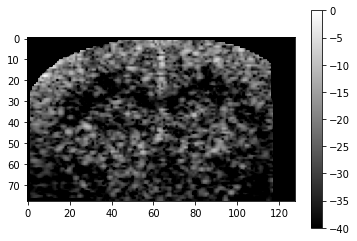

In [59]:
bmode_visu(IQc_raw[0][:,:,0])

In [ ]:
# Load .npz file and split raw and truth part in numpy array
container_raw = np.load('../DL_flow/flow_simu_raw.npz')
IQc_raw = np.array([container_raw[key] for key in container_raw])
IQc_raw = IQc_raw[0]
container_truth = np.load('../DL_flow/flow_simu_truth.npz')
IQc_truth = np.array([container_truth[key] for key in container_truth])
IQc_truth = IQc_truth[0]

IQc_tiled_raw = tile(IQc_raw, 32)

In [33]:
# Predict on tiled image with the model and reconstruct each image with untile
predictions = torch.Tensor().cuda()
for batch in IQc_tiled_raw:
    with torch.no_grad():
        input = Variable(batch.unsqueeze(0).float()).cuda()
        prediction = model(input)
        predictions = torch.cat((predictions, prediction))
# prediction_untiled = untile(predictions, 2, 2)
prediction_untiled = untile(predictions, 2, 4) # Couture

In [34]:
# Improve the localization using local_maxima estimation and threshold
coordinates_tile = []
for i in range(800):
    for j in range(len(predictions[i])):
        coordinates_tile.append(peak_local_max(prediction_untiled[i,0,:,:].cpu().detach().numpy(), threshold_abs= 2, min_distance = 4))
predictions_tile_lmax = np.zeros((256,512,len(coordinates_tile)))

for k in range(len(coordinates_tile)):
    predictions_tile_lmax[coordinates_tile[k][:,0], coordinates_tile[k][:,1], k] = 1      


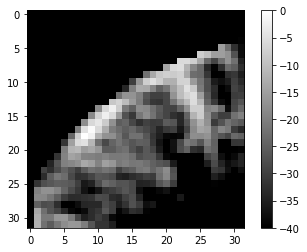

In [74]:
bing = IQc_tiled_raw[0:800,:,:,:]
bing_visu = np.mean(bing.cpu().detach().numpy()**2, axis = 0).squeeze()
bmode_visu(bing_visu)

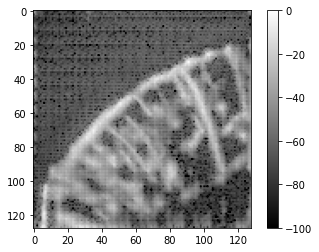

In [76]:
bang = predictions[0:800,:,:,:]
bang_visu = np.sum(bang.cpu().detach().numpy(), axis = 0).squeeze()
bmode_visu(bang_visu,100)

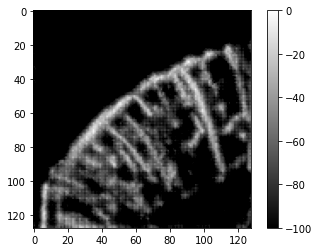

In [77]:
bang = predictions[0:800,:,:,:]
bang_visu = np.mean(bang.cpu().detach().numpy()**2, axis = 0).squeeze()
bmode_visu(bang_visu,100)

In [80]:
# Through the Nt parameter (time) sum up each position for local max of predictions, square mean of input, sum of target, sum of vanilla predictions
test_1 = np.sum(predictions_tile_lmax, axis = 2)
test_2 = np.mean(IQc_raw**2, axis = 2)
# test_2 = np.mean(IQc_raw[0][0:64,:,:]**2, axis = 2) # Couture
# test_3 = np.sum(IQc_truth, axis = 2)
test_4 = np.sum(prediction_untiled.cpu().detach().numpy(), axis = 0).squeeze()

In [81]:
# test_4 = np.delete(test_4, [125,126,127,128,129,253,254,255,256,257,381,382,383,384,385], 1)
# test_4 = np.delete(test_4, [126,127,128], 0)

Sum Prediction


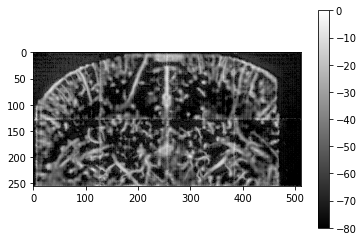

Sum Local Max Prediction


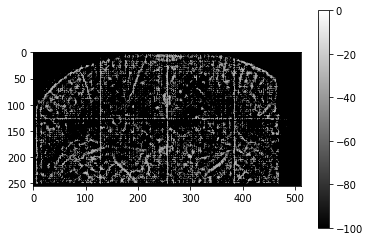

Sum Target


NameError: name 'test_3' is not defined

In [82]:
# Look at the reconstruction of each step of the process
print("Sum Prediction")
bmode_visu(test_4,80)
print("Sum Local Max Prediction")
bmode_visu(test_1,100)
print("Sum Target")
bmode_visu(test_3)
print("Doppler")
bmode_visu(test_2)
# bmode_visu(test_2, 50) # Couture

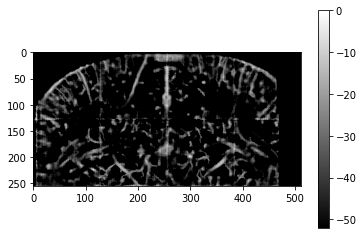

In [72]:
from IPython.display import clear_output
for j in range(5):
    for i in range (50,100):
        if i%2 == 0:
            clear_output(wait=True)
            bmode_visu(test_4,i)
            print("")
    for i in range (100,50,-1):
        if i%2 == 0:
            clear_output(wait=True)
            bmode_visu(test_4,i)
            print("")

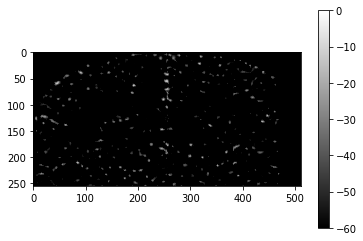

In [71]:
for i in range (0,100):
        if i%1 == 0:
            clear_output(wait=True)
            bmode_visu(prediction_untiled[i,0,:,:],60)


In [388]:
# Here we look at the local max of predctions coordinates vs the targets
result_1 = np.where(test_1 > 1)
listOfCoordinates_1 = list(zip(result_1[0], result_1[1]))
listOfCoordinates_1 = [list(item) for item in listOfCoordinates_1]
listOfCoordinates_1 = np.array(listOfCoordinates_1)

result_2 = np.where(test_3 > 1)
listOfCoordinates_2 = list(zip(result_2[0], result_2[1]))
listOfCoordinates_2 = [list(item) for item in listOfCoordinates_2]
listOfCoordinates_2 = np.array(listOfCoordinates_2)

C:\Users\judel\miniconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



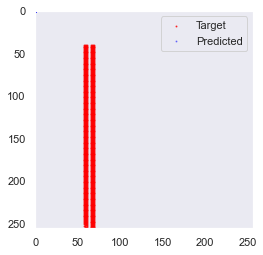

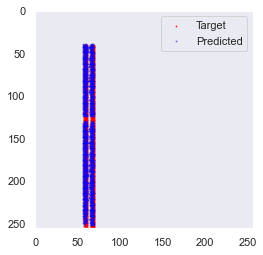

(None, None)

In [395]:
plot_max(np.zeros([256,256]),listOfCoordinates_2),plot_max(listOfCoordinates_1,listOfCoordinates_2)

In [390]:
# Look at the distribution of lights up pixels for predictions, local max of predictions and targets
sum_1 = np.sum(test_1, axis = 0)
sum_3 = np.sum(test_3, axis = 0)
sum_4 = np.sum(test_4, axis = 0)


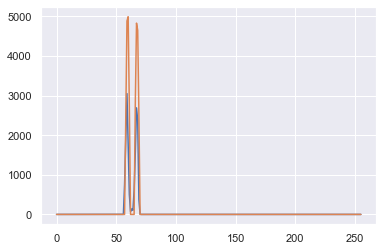

In [392]:
plt.plot(sum_1)
plt.plot(sum_3)
#plt.plot(sum_4)


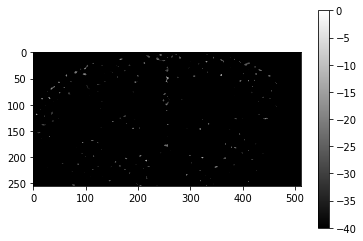

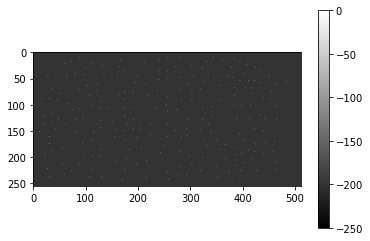

(None, None)

In [81]:
bmode_visu(prediction_untiled[1,0,:,:]),bmode_visu(predictions_tile_lmax[:,:,1],250)

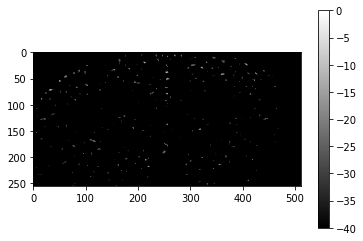

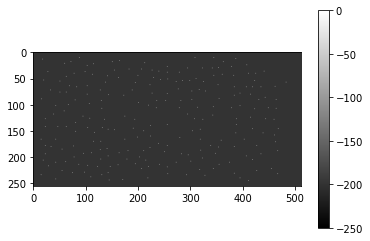

NameError: name 'IQc_truth' is not defined

In [68]:
bmode_visu(prediction_untiled[0,0,:,:]),bmode_visu(predictions_tile_lmax[:,:,0],250),bmode_visu(IQc_truth[:,:,0],250)

In [ ]:
# bmode_visu(IQc_tiled_raw[1,0,:,:].detach().numpy())
# bmode_visu(IQc_raw[:,:,1])
# bmode_visu(IQc_truth[:,:,1], 250)

In [ ]:
# bmode_visu(IQc_truth[:,:,0], 250)

# Plot Target vs Predicted

In [210]:
# We take the peak local max of the peak local max in order to have only the coordinates and we set up a plot of Target vs Prediction
%matplotlib inline
sns.set() # Plot styling
def plot_max(a, b):
    plt.ylim(256,0) # Change the dimension with the output size
    plt.xlim(0,256) # Change the dimension with the output size
    sns.regplot(b[:, 1], b[:, 0], label = "Target", scatter_kws = {"color":"red","alpha":0.7,"s":1}, fit_reg = False, ci = False).legend(loc="best")
    sns.regplot(a[:, 1], a[:, 0], label = "Predicted", scatter_kws = {"color":"blue","alpha":0.4,"s":1}, fit_reg = False, ci = False).legend(loc="best")
    plt.gca().set_aspect('equal', adjustable = 'box')
    plt.grid(False)
    plt.show()
    

# Function to look at Target vs Predicted

In [ ]:
# # Not useful here but interesting function
# def array_in_list(myarr, list_arrays):
#     return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

In [16]:
# Align predictions targets in increasing order for the x coordinate, the targets not predicted will be at the end of the target list
# The ouput of this function should sort the target list according to our prediction:
# Input: Prediction list [[x1,y1],[x2,y2],[x3,y3]] Target List [[x1',y1'],[x4',y4'],[x2',y2'],[x3',y3']]
# Output: Prediction list [[x1,y1],[x2,y2],[x3,y3]] Target List [[x1',y1'],[x2',y2'],[x3',y3'],[x4',y4']]
def align_by_dist(A, B):
    for i in range(len(A)):
        D = [] # This list will contain the index where the euclidean distance is lower than the threshold
        for j in range(len(B)):
            dist = distance.euclidean(A[i], B[j]) # Compute the euclidean distance between a target at index j and a prediction at index i
            if dist <= 4: # Select a treshold for the euclidean distance
                D.append(np.array([dist,j,i])) # Append the euclidean distance and the index of the target and prediction vector
        if D: # If we find an euclidean distance lower than the threshold we can now sort for the index i the list of prediction
            D_sorted = sorted(D,key=lambda elem:elem[0]) # We sort the array of distance lower than the threshold to get the minimum distance for the index i 
            value = D_sorted[0]
            B[value[2].astype(np.int64)], B[value[1].astype(np.int64)] = B[value[1].astype(np.int64)], B[value[2].astype(np.int64)] # We updated the target list position 
            A[value[2].astype(np.int64)] = [1000000,1000000] # We set the value of the predictions very high to not have duplicates when sorting the targets coordinates 
    return B

In [17]:
# Delete all the target micro-bubble that were not predicted, in fact: len(predict) == len(target)
def equal_length(A, B):
    for i in range(len(A) - len(B)):
        B = np.delete(B, -1, 0)
    return A, B

In [18]:
# Select the micro-bubble that were not predicted
def non_predicted(A, B):
    target_not_predicted = B
    for i in range(len(A)):
        target_not_predicted = np.delete(target_not_predicted, 0, 0)
#     print("There is/are", len(B) - len(A), "micro-bubble not predicted at:", target_not_predicted)
    return (len(B) - len(A))

In [19]:
# Take the distance of the well predicted micro-bubble
def distance_pred_target(A, B):
    D = []
    for i in range(len(A)):
        dist = distance.euclidean(A[i], B[i])
        if dist <= 4:
            D.append(dist)
        else:
            D.append(np.nan)
    return D

In [20]:
# Select the micro-bubble predicted but not accuratly
def distance_nonull(D, A, B):
    j = 0
    D_not_p = []
    for i in range(len(D)):
        if D[i] != 0:
#             print("The micro-bubble predicted at", A[i], "should be at", B[i], "the euclidean distance here is equal to:", D[i])
            D_not_p.append(D[i])
            j += 1
    return j, D_not_p

# Dataframe to compare model precision

In [ ]:
# We use it when running the program with different models (need to be executed only once and after comment this code)
df = pd.DataFrame(columns=['Nom du Model', 'ID Image', 'Mb non prédites', 'Mb bien prédites', 'Mb mal prédites', 'Distance moyenne entre toutes les Mb', 'Distance moyenne entre les Mb mal prédites', 'Nombre total de Mb'])

In [ ]:
# We use it as a temporary dataframe each time we run the code (need to be executed each time)
df1 = pd.DataFrame(columns=['Nom du Model', 'ID Image', 'Mb non prédites', 'Mb bien prédites', 'Mb mal prédites', 'Distance moyenne entre toutes les Mb', 'Distance moyenne entre les Mb mal prédites', 'Nombre total de Mb'])

In [ ]:
for i in range(1,5): # Select which data we want in the test set
    for j in range(predictions[i].size()[0]):
        list_a, list_b = predictions_lmax[:,:,i], targets[i][j,0,:,:].cpu().detach().numpy() # We take the coordinates of targets and predictions
        a, b = peak_local_max(list_a), peak_local_max(list_b) # /!\ Remove .cpu() if we don't have cuda available /!\
#         plot_max(a, b) # Plot for a given image Predict Local Max vs Target
        a_sorted = sorted(a, key=lambda x: x[0]) # We sort in the increasing order both list by looking at the x coordinate
        b_sorted = sorted(b, key=lambda x: x[0])
        b_final = align_by_dist(a_sorted, b_sorted) # We sort the targets to align target and predictions and we have the non predicted coordinates at the end of the target list
        a_eq, b_eq = equal_length(sorted(a, key=lambda x: x[0]), b_final) # We select the targets that have been predicted
        mb_not_predicted = non_predicted(sorted(a, key=lambda x: x[0]), b_final) # We select the targets that have not been predicted
        avg_euc_dist = distance_pred_target(a_eq, b_eq) # We compute the distance between the predictions and the targets
#         print("The average distance between all the predicted points and the target is", np.nanmean(avg_euc_dist))        
        j_no_null, distance_bad_pred = distance_nonull(avg_euc_dist, a_eq, b_eq) # We select the predictions that are not perfectly accurate
        if not distance_bad_pred: # If there are no bad predictions we just set this number to 0
            distance_bad_pred = 0
#         print("The average distance between the bad predicted points and the target is", np.nanmean(distance_bad_pred))
#         print("The number of well predicted micro-bubble is", len(avg_euc_dist) - j_no_null, "over", len(b_final), "that we were aiming for.")
        df1.loc[i] = ["Van Sloun Modified Model (3)"] + [i + 1] + [mb_not_predicted] + [len(avg_euc_dist) - j_no_null] + [j_no_null] + [np.nanmean(avg_euc_dist)] + [np.nanmean(distance_bad_pred)] + [len(b_final)]
df = pd.concat([df, df1])

In [ ]:
# # Sort the dataframe by different parameter and ascending type
# df.sort_values(by=['ID Image', 'Mb bien prédites', 'Distance moyenne entre les Mb mal prédites'], ascending=[True, True, False], inplace=True)

In [ ]:
# # Needed if we want to take a capture of the table with the performance for the same image of every models
# df_img_1 = df.loc[df['ID Image'] == 1].reset_index(drop=True).style.set_properties(**{'text-align': 'left'})

# df_img_1

In [ ]:
# Needed to for the plot to transpose the the dataframe
# df_pivot = df.pivot(index='ID Image', columns='Nom du Model', values='Distance moyenne entre les Mb mal prédites')

In [ ]:
# # Plot the performance of the different models
# df_pivot.plot().legend(loc="best", prop={'size': 9})
# plt.ylim(0,2)
# plt.xlim(1,10)
# plt.ylabel('Distance moyenne entre les Mb mal prédites')
# plt.grid(False)

# Model performance by Concentration and SNR

### In this section we will plot the performance (Concentration, SNR, % of well prediction) of liu and vansloun modified model

In [29]:
# We use it when running the program with different models (need to be executed only once and after comment this code)
df_perf = pd.DataFrame(columns=['Nom du Model', 'Distance moyenne entre les Mb mal prédites', "Concentration", "SNR", "Pourcentage de Mb bien prédites", "Pourcentage de Mb non prédites"]) 

In [30]:
# We use it as a temporary dataframe each time we run the code (need to be executed each time)
df2 = pd.DataFrame(columns=['Nom du Model', 'Distance moyenne entre les Mb mal prédites', "Concentration", "SNR", "Pourcentage de Mb bien prédites", "Pourcentage de Mb non prédites"]) 

In [31]:
D = []
Wp_p = []
Np_p = []
concentration = 30 # This is the initial concentration for the data
for i in range(len(predictions)):
    for j in range(predictions[i].size()[0]):
        list_a, list_b = predictions_lmax[:,:,i], targets[i][j,0,:,:].cpu().detach().numpy() # We take the coordinates of targets and predictions
        a, b = peak_local_max(list_a), peak_local_max(list_b) # /!\ Remove .cpu() if we don't have cuda available /!\
#         plot_max(a, b) # Plot for a given image Predict Local Max vs Target
        a_sorted = sorted(a, key=lambda x: x[0]) # We sort in the increasing order both list by looking at the x coordinate
        b_sorted = sorted(b, key=lambda x: x[0])
        b_final = align_by_dist(a_sorted, b_sorted) # We sort the targets to align target and predictions and we have the non predicted coordinates at the end of the target list
        a_eq, b_eq = equal_length(sorted(a, key=lambda x: x[0]), b_final) # We select the targets that have been predicted
        mb_not_predicted = non_predicted(sorted(a, key=lambda x: x[0]), b_final) # We select the targets that have not been predicted
        avg_euc_dist = distance_pred_target(a_eq, b_eq) # We compute the distance between the predictions and the targets
        j_no_null, distance_bad_pred = distance_nonull(avg_euc_dist, a_eq, b_eq) # We select the predictions that are not perfectly accurate
        if not distance_bad_pred: # If there are no bad predictions we just set this number to 0
            distance_bad_pred = 0
        D.append(np.sqrt(np.nanmean(np.square(distance_bad_pred)))) # Store the mean distance between bad predicted Mbs in an array
        percentage_well_predicted = (len(avg_euc_dist) - j_no_null) / len(b_final) # % of well predicted Mbs
        Wp_p.append(percentage_well_predicted) # Store the % of well predicted Mbs in an array
        percentage_non_predicted = (mb_not_predicted) / len(b_final) # % of non predicted Mbs
        Np_p.append(percentage_non_predicted) # Store the % of non predicted Mbs in an array
        if (i+1)%30 == 1: # Since we have 30 input per concentration we compute the performance for this group of the same concentration
            df2.loc[i] = ["Van sloun Model (0.7_6_a15)"] + [np.nanmean(D)] + [concentration] + [20] + [np.nanmean(Wp_p) * 100] + [np.nanmean(Np_p) * 100]# 40 here is the SNR, it is needed to be change if you take data with a new SNR to observe the difference 
            concentration += 20 # The gap between 2 concentration is 20
df_perf = pd.concat([df_perf, df2])

In [32]:
df_perf

,Nom du Model,Distance moyenne entre les Mb mal prédites,Concentration,SNR,Pourcentage de Mb bien prédites,Pourcentage de Mb non prédites
0,Van sloun Model (0.7_6_a15),1.732051,30,20,75.000000,12.500000
30,Van sloun Model (0.7_6_a15),1.117988,50,20,76.850273,8.599267
60,Van sloun Model (0.7_6_a15),1.229882,70,20,72.305437,8.638129
90,Van sloun Model (0.7_6_a15),1.250973,90,20,69.147217,9.022414
120,Van sloun Model (0.7_6_a15),1.257142,110,20,67.497338,9.648788
150,Van sloun Model (0.7_6_a15),1.263065,130,20,65.087899,10.030917
180,Van sloun Model (0.7_6_a15),1.292868,150,20,62.905833,10.790172
210,Van sloun Model (0.7_6_a15),1.308172,170,20,60.360243,11.451406
240,Van sloun Model (0.7_6_a15),1.314165,190,20,57.661040,12.250949
270,Van sloun Model (0.7_6_a15),1.325610,210,20,55.520590,12.937429


In [25]:
df_perf

,Nom du Model,Distance moyenne entre les Mb mal prédites,Concentration,SNR,Pourcentage de Mb bien prédites,Pourcentage de Mb non prédites
0,Van sloun Model (0.7_6_a15),1.527525,30,20,75.000000,6.250000
30,Van sloun Model (0.7_6_a15),1.072216,50,20,77.997621,9.382000
60,Van sloun Model (0.7_6_a15),1.155949,70,20,73.657880,9.520834
90,Van sloun Model (0.7_6_a15),1.195470,90,20,70.573130,9.769170
120,Van sloun Model (0.7_6_a15),1.222771,110,20,68.290773,10.458608
150,Van sloun Model (0.7_6_a15),1.252666,130,20,65.571963,11.205070
180,Van sloun Model (0.7_6_a15),1.273266,150,20,63.045502,11.968797
210,Van sloun Model (0.7_6_a15),1.290285,170,20,60.563793,12.622502
240,Van sloun Model (0.7_6_a15),1.298510,190,20,57.958729,13.428486
270,Van sloun Model (0.7_6_a15),1.306661,210,20,55.703121,14.316308


# Model Performance for Tiled images

In [37]:
# We use it when running the program with different models (need to be executed only once and after comment this code)
df_perf_2 = pd.DataFrame(columns=['Nom du Model', 'Distance moyenne entre les Mb mal prédites', "Concentration", "SNR", "Pourcentage de Mb bien prédites", "Pourcentage de Mb non prédites"]) 

In [38]:
# We use it as a temporary dataframe each time we run the code (need to be executed each time)
df3 = pd.DataFrame(columns=['Nom du Model', 'Distance moyenne entre les Mb mal prédites', "Concentration", "SNR", "Pourcentage de Mb bien prédites", "Pourcentage de Mb non prédites"]) 

In [39]:
D = []
Wp_p = []
Np_p = []
for i in range(len(prediction_untiled)):
    for j in range(prediction_untiled[i].size()[0]):
        list_a, list_b = predictions_tile_lmax[:,:,i], IQc_truth[:,:,i] # We take the coordinates of targets and predictions
        a, b = peak_local_max(list_a), peak_local_max(list_b) # /!\ Remove .cpu() if we don't have cuda available /!\
#         plot_max(a, b) # Plot for a given image Predict Local Max vs Target
        a_sorted = sorted(a, key=lambda x: x[0]) # We sort in the increasing order both list by looking at the x coordinate
        b_sorted = sorted(b, key=lambda x: x[0])
        b_final = align_by_dist(a_sorted, b_sorted) # We sort the targets to align target and predictions and we have the non predicted coordinates at the end of the target list
        a_eq, b_eq = equal_length(sorted(a, key=lambda x: x[0]), b_final) # We select the targets that have been predicted
        mb_not_predicted = non_predicted(sorted(a, key=lambda x: x[0]), b_final) # We select the targets that have not been predicted
        avg_euc_dist = distance_pred_target(a_eq, b_eq) # We compute the distance between the predictions and the targets
        j_no_null, distance_bad_pred = distance_nonull(avg_euc_dist, a_eq, b_eq) # We select the predictions that are not perfectly accurate
        if not distance_bad_pred: # If there are no bad predictions we just set this number to 0
            distance_bad_pred = 0
        D.append(np.sqrt(np.nanmean(np.square(distance_bad_pred)))) # Store the mean distance between bad predicted Mbs in an array
        percentage_well_predicted = (len(avg_euc_dist) - j_no_null) / len(b_final) # % of well predicted Mbs
        Wp_p.append(percentage_well_predicted) # Store the % of well predicted Mbs in an array
        percentage_non_predicted = (mb_not_predicted) / len(b_final) # % of non predicted Mbs
        Np_p.append(percentage_non_predicted) # Store the % of non predicted Mbs in an array
df3.loc[0] = ["Van sloun Model (0.7_6_a15)"] + [np.nanmean(D)] + [50] + [5] + [np.nanmean(Wp_p) * 100] + [np.nanmean(Np_p) * 100]# 40 here is the SNR, it is needed to be change if you take data with a new SNR to observe the difference 
df_perf_2 = pd.concat([df_perf_2, df3])

In [357]:
df_perf_2

,Nom du Model,Distance moyenne entre les Mb mal prédites,Concentration,SNR,Pourcentage de Mb bien prédites,Pourcentage de Mb non prédites
0,Van sloun Model (0.7_6_a15),1.378339,4,5,19.776786,18.299405
0,Van sloun Model (0.7_6_a15),1.697479,15,5,8.610292,46.186474
0,Van sloun Model (0.7_6_a15),1.640060,30,5,6.002623,63.006275
0,Van sloun Model (0.7_6_a15),1.557806,50,5,4.686689,73.596233
0,Van sloun Model (0.7_6_a15),1.387946,100,5,3.888655,82.961316


In [40]:
df_perf_2

,Nom du Model,Distance moyenne entre les Mb mal prédites,Concentration,SNR,Pourcentage de Mb bien prédites,Pourcentage de Mb non prédites
0,Van sloun Model (0.7_6_a15),1.700372,50,5,8.123837,46.613349


In [ ]:
# # We sort the value according to Concentration and SNR to have a nice well sorted data frame
# df_perf.sort_values(by=['Concentration', 'SNR'], ascending=[True, True], inplace=True)
# df_perf.to_csv(r'../CSV_model_perf/liu075_perf.csv', index = False)

In [367]:
# Read the csv dataframe saved before
data_1 = pd.read_csv('../CSV_model_perf/vansloun3_perf.csv')
data_2 = pd.read_csv('../CSV_model_perf/liu075_perf.csv')
data_3 = pd.read_csv('../CSV_model_perf/vansloun6_a15_tube_perf.csv')

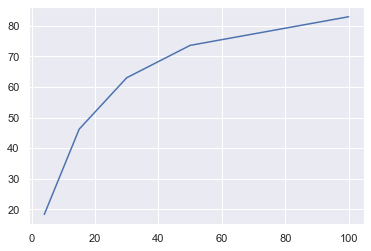

In [372]:
plt.plot(data_3['Concentration'],data_3['Pourcentage de Mb non prédites'])

In [ ]:
# Concatenate and sort the values of the models selected to be plot
df_plot = pd.concat([data_1,data_2])
df_plot.sort_values(by=['Concentration', 'SNR'], ascending=[True, True], inplace=True)

In [369]:
# Plot the 3D graph with the parameter wanted
import plotly.express as px 

# fig = px.scatter_3d(df_plot, x = 'SNR', y = 'Concentration', z = 'Pourcentage de Mb bien prédites', color = 'Nom du Model')
fig = px.scatter_3d(data_3, x = 'Pourcentage de Mb non prédites', y = 'Concentration', z = 'Distance moyenne entre les Mb mal prédites', color = 'Nom du Model')
fig.show()

# Clean the memory

In [ ]:
# del model

In [3]:
import GPUtil
import gc
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_allocated())
GPUtil.showUtilization()
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.empty_cache())
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_allocated())
GPUtil.showUtilization()

0
0
| ID | GPU | MEM |
------------------
|  0 |  0% | 16% |
None
0
0
| ID | GPU | MEM |
------------------
|  0 | 35% | 16% |
